# Clustering

## Loading and Cleaning Data

First, we follow ProPublica's.

In [72]:
import numpy as np
import pandas as pd
raw_data = pd.read_csv("./compas-scores-two-years.csv")

In [73]:
df = raw_data.query('days_b_screening_arrest <= 30 and ' + 
                    'days_b_screening_arrest >= -30 and ' +
                    'is_recid != -1 and ' +
                    'c_charge_degree != "O" and ' +
                    'score_text != "N/A"'
                   )
print("Raw {} - filtered {} = Remaining {}".format(len(raw_data), len(raw_data) - len(df), len(df)))

Raw 7214 - filtered 1042 = Remaining 6172


Further filtering:
- Some duplicated variables are removed.
- Text variables with no expectation for interesting correlations AND a large number of unique values are removed.
- Other text variables are converted to numeric values.
    - Code Male as 0/False, Female as 1/True

In [74]:
df_filter = df.copy()
del df_filter['violent_recid']
if df_filter['decile_score'].equals(df_filter['decile_score.1']):
    # This is true
    del df_filter['decile_score.1']
if df_filter['priors_count'].equals(df_filter['priors_count.1']):
    # This is true
    del df_filter['priors_count.1']

df_corr = df_filter.corr()
for _, i in enumerate(df_corr.index):
    df_corr.loc[i,i] = np.nan
max_mag_corrs = df_corr.abs().max()
    
uninteresting_text_vars = ['name','first','last','type_of_assessment','v_type_of_assessment']
for uninteresting in uninteresting_text_vars:
    del df_filter[uninteresting]

df_filter['sex'] = df_filter['sex'].map(lambda x: x == 'Female').astype(np.bool)
df_filter['c_did_felony'] = df_filter['c_charge_degree'].map(lambda x: x == 'F').astype(np.bool)

race_code = {name: rank for rank, name in enumerate(df['race'].value_counts().index)}
df_filter['race_code'] = df_filter['race'].map(lambda x: race_code[x])


df_filter['juv_all_count'] = df_filter['juv_fel_count'] + df_filter['juv_misd_count'] + df_filter['juv_other_count']
df_filter['ALL_priors_count'] = df_filter['juv_all_count'] + df_filter['priors_count']

In [75]:
df_filter.select_dtypes(exclude=['object']).head()

,id,sex,age,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_days_from_compas,...,is_violent_recid,v_decile_score,start,end,event,two_year_recid,c_did_felony,race_code,juv_all_count,ALL_priors_count
0,1,False,69,0,1,0,0,0,-1.0,1.0,...,0,1,0,327,0,0,True,3,0,0
1,3,False,34,0,3,0,0,0,-1.0,1.0,...,1,1,9,159,1,1,True,0,0,0
2,4,False,24,0,4,0,1,4,-1.0,1.0,...,0,3,0,63,0,1,True,0,1,5
5,7,False,44,0,1,0,0,0,0.0,0.0,...,0,1,1,853,0,0,False,3,0,0
6,8,False,41,0,6,0,0,14,-1.0,1.0,...,0,2,5,40,1,1,True,1,0,14


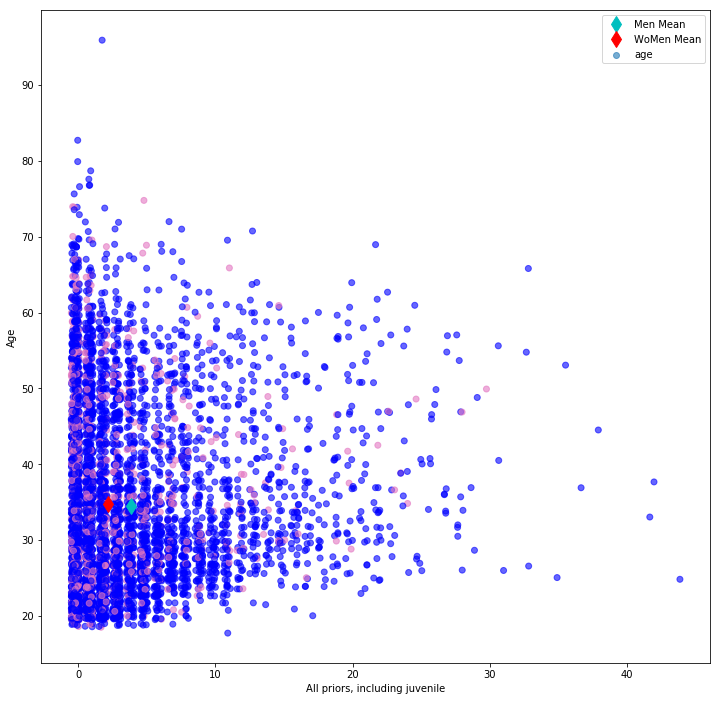

In [77]:
jitter_width = 0.6
def get_jitter(N):
    return np.random.rand(N) * jitter_width - 0.5

import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
fig, axarr = plt.subplots(figsize=(12,12))

cmap = pltcolors.ListedColormap(['b','tab:pink'])
x_jitter = get_jitter(len(df_filter))
y_jitter = get_jitter(len(df_filter))
axarr.scatter(df_filter['ALL_priors_count'] + x_jitter, df_filter['age'] + y_jitter,
              c=df_filter['sex'], alpha=0.6, cmap=cmap)

# mean_priors = [df_filter[~df_filter['sex']]['ALL_priors_count'].mean(),
#                df_filter[df_filter['sex']]['ALL_priors_count'].mean()]
mean_men = [df_filter[~df_filter['sex']]['ALL_priors_count'].mean(),
            df_filter[~df_filter['sex']]['age'].mean()]
mean_women = [df_filter[df_filter['sex']]['ALL_priors_count'].mean(),
              df_filter[df_filter['sex']]['age'].mean()]
# mean_ages = [df_filter[~df_filter['sex']]['age'].mean(),
#                df_filter[df_filter['sex']]['age'].mean()]
axarr.plot(mean_men[0], mean_men[1], 'cd', markersize=12, label='Men Mean')
axarr.plot(mean_women[0], mean_women[1], 'rd', markersize=12, label='WoMen Mean')
# axarr.scatter(mean_priors, mean_ages, c=['c','r'], s=100, marker='d')

axarr.set_ylabel("Age")
axarr.set_xlabel("All priors, including juvenile")
axarr.legend()
plt.show()

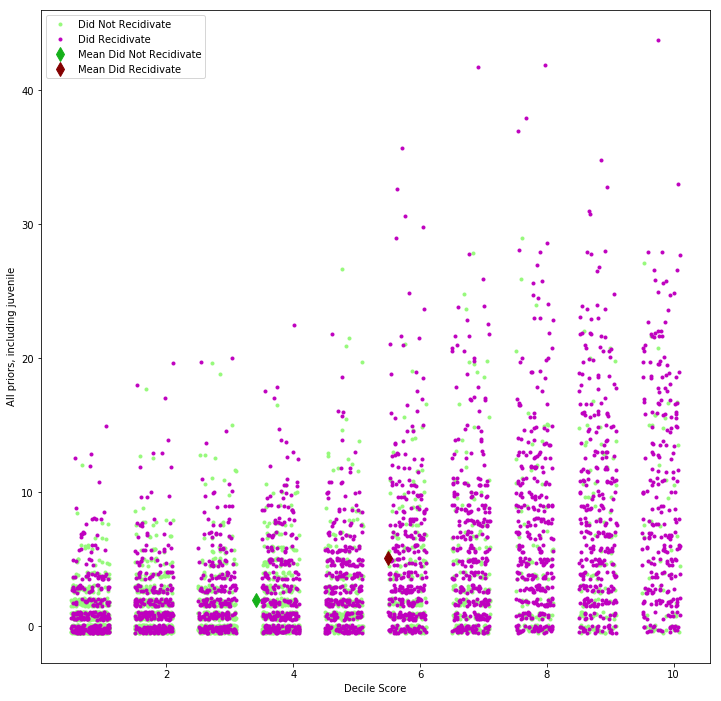

In [82]:
fig, axarr = plt.subplots(figsize=(12,12))

cmap = pltcolors.ListedColormap(['y','tab:purple'])
x_jitter = get_jitter(len(df_filter))
y_jitter = get_jitter(len(df_filter))
false_xs = df_filter[~df_filter['is_recid'].astype(np.bool)]['decile_score']
true_xs = df_filter[df_filter['is_recid'].astype(np.bool)]['decile_score']
false_ys = df_filter[~df_filter['is_recid'].astype(np.bool)]['ALL_priors_count']
true_ys = df_filter[df_filter['is_recid'].astype(np.bool)]['ALL_priors_count']
axarr.plot(false_xs + get_jitter(len(false_xs)), false_ys + get_jitter(len(false_ys)), '.', color='xkcd:light green', label='Did Not Recidivate')
axarr.plot(true_xs + get_jitter(len(true_xs)), true_ys + get_jitter(len(true_ys)), 'm.', label='Did Recidivate')
# axarr.scatter(df_filter['decile_score'] + x_jitter, df_filter['ALL_priors_count'] + y_jitter,
#               c=df_filter['is_recid'], alpha=0.6, cmap=cmap)

# mean_scores = [df_filter[~df_filter['is_recid']]['decile_score'].mean(),
#                df_filter[df_filter['is_recid']]['decile_score'].mean()]
# mean_no_recid = [df_filter[~df_filter['is_recid']]['decile_score'].mean(),
#                  df_filter[~df_filter['is_recid']]['ALL_priors_count'].mean()]
# mean_recid = [df_filter[df_filter['is_recid']]['decile_score'].mean(),
#               df_filter[df_filter['is_recid']]['ALL_priors_count'].mean()]
# mean_priors = [df_filter[~df_filter['is_recid']]['ALL_priors_count'].mean(),
#                df_filter[df_filter['is_recid']]['ALL_priors_count'].mean()]
# axarr.scatter(mean_priors, mean_ages, c=['c','r'], s=100, marker='d')
axarr.plot(false_xs.mean(), false_ys.mean(), 'd', markersize=10, color='xkcd:green', label='Mean Did Not Recidivate')
axarr.plot(true_xs.mean(), true_ys.mean(), 'd', markersize=10, color='xkcd:dark red', label='Mean Did Recidivate')

axarr.set_xlabel("Decile Score")
axarr.set_ylabel("All priors, including juvenile")
axarr.legend()
plt.show()

In [21]:
df_filter.select_dtypes(include=['object']).head()


,compas_screening_date,dob,age_cat,race,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_charge_degree,...,vr_offense_date,vr_charge_desc,type_of_assessment,score_text,screening_date,v_type_of_assessment,v_score_text,v_screening_date,in_custody,out_custody
0,2013-08-14,1947-04-18,Greater than 45,Other,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,F,...,NaN,NaN,Risk of Recidivism,Low,2013-08-14,Risk of Violence,Low,2013-08-14,2014-07-07,2014-07-14
1,2013-01-27,1982-01-22,25 - 45,African-American,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,F,...,2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,Low,2013-01-27,Risk of Violence,Low,2013-01-27,2013-01-26,2013-02-05
2,2013-04-14,1991-05-14,Less than 25,African-American,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,F,...,NaN,NaN,Risk of Recidivism,Low,2013-04-14,Risk of Violence,Low,2013-04-14,2013-06-16,2013-06-16
5,2013-11-30,1971-08-22,25 - 45,Other,2013-11-30 04:50:18,2013-12-01 12:28:56,13022355MM10A,2013-11-30,NaN,M,...,NaN,NaN,Risk of Recidivism,Low,2013-11-30,Risk of Violence,Low,2013-11-30,2013-11-30,2013-12-01
6,2014-02-19,1974-07-23,25 - 45,Caucasian,2014-02-18 05:08:24,2014-02-24 12:18:30,14002304CF10A,2014-02-18,NaN,F,...,NaN,NaN,Risk of Recidivism,Medium,2014-02-19,Risk of Violence,Low,2014-02-19,2014-03-31,2014-04-18


In [29]:
df_filter[['compas_screening_date','c_arrest_date']].apply(pd.to_datetime, errors='coerce').head(20)

,compas_screening_date,c_arrest_date
0,2013-08-14,NaT
1,2013-01-27,NaT
2,2013-04-14,NaT
5,2013-11-30,NaT
6,2014-02-19,NaT
7,2013-08-30,2013-08-29
8,2014-03-16,NaT
10,2013-11-26,NaT
11,2013-10-03,NaT
12,2013-01-01,NaT


In [23]:
df_filter.apply(pd.to_datetime).select_dtypes(include=['object']).head()

TypeError: ("<class 'bool'> is not convertible to datetime", 'occurred at index sex')